In [82]:
import autograd.numpy as np
import openpyxl as xl
import sympy as sp
import matplotlib.pyplot as plt

from sympy.abc import x
from sympy.utilities.lambdify import lambdify, implemented_function
from autograd import grad, jacobian


In [83]:
'''Import data and get the length of data'''
x_data =np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
y_data =np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
n = len(x_data)

The fitting function is:
$$
f(E) = \frac{f_r}{(E-E_r)^2+\Gamma^2/4}
$$
Which can be simplified to:
$$
g(x) = \frac{a_1}{(x-a_2)^2+a_3}
$$
Thus function need to be minimized is:
$$
\chi^2 = \sum_{i=1}^{N_D}\left(y_i-g(x_i)\right)^2=0
$$
To get the minimum of $\chi^2$, we have to take partial derivatives on $a_i \ (i = 1,2,3)$ and set them to zero:
$$\begin{split}
&f_1(a_1,a_2,a_3) =\sum_{i=1}^{N_D}\frac{(y_i - g(x_i,a))}{(x_i-a_2)^2+a_3}=0\\
&f_2(a_1,a_2,a_3) =\sum_{i=1}^{N_D}\frac{(y_i - g(x_i,a))(x_i-a_2)}{((x_i-a_2)^2+a_3)^2}=0\\
&f_3(a_1,a_2,a_3) =\sum_{i=1}^{N_D}\frac{(y_i - g(x_i,a))}{((x_i-a_2)^2+a_3)^2}=0
\end{split}$$

In [84]:
'''Take partial derivatives'''
x, a, b, c= sp.symbols('x a b c')
f = a/((x-b)**2+c)
f_a = sp.diff(f,a)
f_b = sp.diff(f,b)
f_c = sp.diff(f,c)

print(f_a)
print(f_b)
print(f_c)

lam_f_a = lambdify([x, b, c], f_a)
lam_f_b = lambdify([x, a, b, c], f_b)
lam_f_c = lambdify([x, a, b, c], f_c)


1/(c + (-b + x)**2)
a*(-2*b + 2*x)/(c + (-b + x)**2)**2
-a/(c + (-b + x)**2)**2


In [85]:
# '''Three function that need to be fitted through Newton Raphson'''
# def func1(x):

#     sr_diff = 0
#     for i in range(n):
#         sr_diff += (y_data[i] - x[0]/((x_data[i]-x[1])**2+x[2]))/((x_data[i]-x[1]**2)+x[2])
   
#     return sr_diff


# def func2(x):

#     sr_diff = 0
#     for i in range(n):
#         sr_diff += (y_data[i] - x[0]/((x_data[i]-x[1])**2+x[2]))*2*x[0]*(x_data[i]-x[1])/((x_data[i]-x[1])**2+x[2])**2
    
#     return sr_diff

# def func3(x):

#     sr_diff = 0
#     for i in range(n):
#         sr_diff += (y_data[i] - x[0]/((x_data[i]-x[1])**2+x[2]))*(-x[0])/((x_data[i]-x[1]**2)+x[2])**2
    
#     return sr_diff

In [86]:
'''Define least square function'''
def g(x,a):
    g = a[0]/((x-a[1])**2+a[2])
    return g

def chi_square(a):
    chi_square = 0
    for i in range(n):
        chi_square += (y_data[i] - g(x_data[i],a))^2
    return chi_square

In [87]:
'''Four functions that need to be fitted through Newton Raphson'''
def func1(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - a[0]/((x_data[i]-a[1])**2+a[2]))*lam_f_a(x=x_data[i], b=a[1], c=a[2])
   
    return diff


def func2(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - a[0]/((x_data[i]-a[1])**2+a[2]))*lam_f_b(x=x_data[i], a=a[0], b=a[1], c=a[2])
    
    return diff

def func3(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - a[0]/((x_data[i]-a[1])**2+a[2]))*lam_f_c(x=x_data[i], a=a[0], b=a[1], c=a[2])
    
    return diff

In [88]:
'''Take Jacobian'''
jac_func1 = jacobian(func1)
jac_func2 = jacobian(func2)
jac_func3 = jacobian(func3)



In [89]:
i = 0
error = 100
tol = 1e-6
maxiter = 1000
M = 3
N = 3

x_0 = np.array([625*80,7e+01,625], dtype=float).reshape(N,1)
fun_evaluate = np.array([func1(x_0),func2(x_0),func3(x_0)]).reshape(M,1)

er = []
iter = []
while np.any(error > tol) and i < maxiter:
    
    func_evaluate = np.array([func1(x_0),func2(x_0),func3(x_0)]).reshape(M,1)
    flat_x_0 = x_0.flatten()
    jac = np.array([jac_func1(flat_x_0),jac_func2(flat_x_0),jac_func3(flat_x_0)])
    jac.reshape(M,N)

    x_new = x_0 - np.linalg.inv(jac)@func_evaluate
    error = (abs(x_new - x_0)/x_0)
    
    x_0 = x_new

    print(i)
    print(error)
    print('-'*10)

    er.append(error)
    iter.append(i)
    
    i += 1
    
print('The Solution is: {}'.format(x_new))
print("LHS of function 1: {}".format(np.around(func1(x_new),12)))
print("LHS of function 2: {}".format(np.around(func2(x_new),12)))
print("LHS of function 3: {}".format(np.around(func3(x_new),12)))

0
[[0.29565926]
 [0.09225464]
 [0.25889539]]
----------
1
[[0.02711742]
 [0.0140445 ]
 [0.00440098]]
----------
2
[[0.00516076]
 [0.00049207]
 [0.00699356]]
----------
3
[[4.91004801e-05]
 [1.19868972e-06]
 [7.42521412e-05]]
----------
4
[[8.31910981e-09]
 [1.47254992e-13]
 [1.30571047e-08]]
----------
The Solution is: [[66886.38989133]
 [   77.49357897]
 [  788.88385761]]
LHS of function 1: [-0.]
LHS of function 2: [0.]
LHS of function 3: [0.]


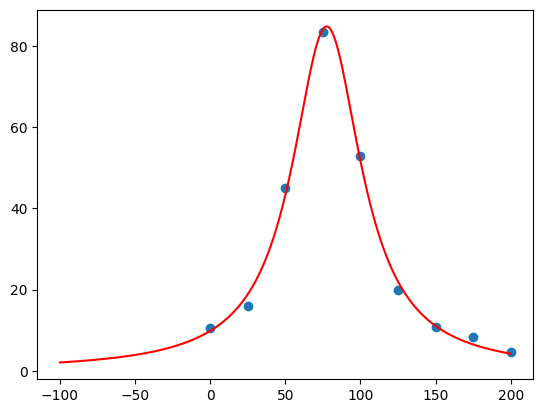

In [90]:
plt.scatter(x_data,y_data)
x = np.linspace(-100,200,600)
y = x_new[0]/((x-x_new[1])**2+x_new[2])
plt.plot(x,y,'r')
plt.show()